# Objective
Use an Artificial Neural Net to fit a model to classify hand-written digits (MNIST).

Sources:
    
* https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

* https://github.com/pytorch/examples/blob/master/mnist/main.py

# Setup
Import the relevant packages

In [7]:
import os
import pandas as pd
import numpy as np
import random

# packages for modelling and evaluation
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
    
# packages for plotting
import matplotlib.pyplot as plt

# set a fixed random state to produce the same results
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Read Data
    
The data are given in a csv table. The first column is the label, the other coloumns are the pixels of the flattened image.

In [8]:
path = "/home/frauke/GAN/data/MNIST"
data = pd.read_csv(os.path.join(path, "train.csv"))
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare the Data

In [9]:
# generate train and validation set
train_data, valid_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'Data shape after splitting:')
print(f'Train Dataset: {train_data.shape}')
print(f'Validation Dataset: {valid_data.shape}')

Data shape after splitting:
Train Dataset: (33600, 785)
Validation Dataset: (8400, 785)


# Define the Dataset

**Note:**
    
For MNIST it is possible to directly download the Dataset via ```from torchvision.datasets import MNIST```. In this notebook however a dataset is constructed by hand in order to demonstrate the workflow. 
    
For more detailed information about pytorch datasets see https://github.com/utkuozbulak/pytorch-custom-dataset-examples

In [10]:
class MNISTDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        '''
        data_frame: data as csv data frame
        transform: optional transform to be applied to a sample
        '''
    
        self.X = np.array(data_frame.iloc[:,1:]).astype(float)
        self.y = np.array(data_frame.iloc[:,0]).astype(float)
        # reshape X (#samples, #channels, width, height)
        self.X = self.X.reshape(self.X.shape[0], 28, 28, 1)
        self.transform = transform
        print(f'Data shape: X: {self.X.shape}, y: {self.y.shape}')
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:\
            x = self.transform(x)
        return x, y

# Define the Model
    
This is a dense neural net using linear layers (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [11]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        
        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer1 = nn.Linear(28*28, 256) # in_features, out_features
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
    def forward(self, x):
        batch_size, channels, width, height = x.size()
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        x = torch.log_softmax(x, dim=1)
        
        return x

# Define Training Loop

In [18]:
def train(model, device, train_dataloader, optimizer, criterion, epoch, print_every):

    # create empty list to store the train losses
    train_loss = []
    correct = 0
    # create an empty list to store the predictions
    predictions = []

    # set model to training mode
    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):

       # set data to device
        data, target = data.to(device), target.to(device)

        # set optimizer to zero
        optimizer.zero_grad()

        # apply model
        logits = model(data.float())

        # calculate loss
        loss = criterion(logits, target.long())
        train_loss.append(loss.item())

        # backpropagation
        loss.backward()
        
        # update
        optimizer.step()
        
        # print the loss every x batches
        if batch_idx % print_every == 0:
            percent = 100. * batch_idx / len(train_dataloader)
            print(f'Train Epoch {epoch} \
            [{batch_idx * len(data)}/{len(train_dataloader.dataset)} \
            ({percent:.0f}%)]\\tLoss: {loss.item():.6f}')

        # get the index of the max log-probability
        pred = logits.argmax(dim=1, keepdim=True)  
        predictions.append(pred)
        #print(logits)
        #print(pred)
        #print(target)
        correct += pred.eq(target.view_as(pred)).sum().item()

    # total training loss
    train_loss = torch.mean(torch.tensor(train_loss))
    epoch_accuracy = correct/len(train_dataloader.dataset)

    return epoch_accuracy, train_loss

# Define Validation Loop

In [20]:
def valid(model, device, val_dataloader, criterion):
    
    # create an empty list to store the loss
    val_loss = []
    correct = 0
    # create an empty list to store the predictions
    predictions = []

    # set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for data, target in val_dataloader:
            
            # set data to device
            data, target = data.to(device), target.to(device)

            # apply model
            logits = model(data.float()).double()

            # append current loss
            loss = criterion(logits, target.long())
            val_loss.append(loss.item())

            # get the index of the max log-probability
            pred = logits.argmax(dim=1, keepdim=True)  
            predictions.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # total validation loss
    val_loss = torch.mean(torch.tensor(val_loss))
    epoch_accuracy = correct/len(val_dataloader.dataset)
    print(f'Validation: Average loss: {val_loss.item():.4f}, \
            Accuracy: {epoch_accuracy:.4f} \
           ({100. * correct/len(val_dataloader.dataset):.0f}%)')
    return predictions, epoch_accuracy, val_loss

In [30]:
# hyperparamters 
batch_size = 64
epochs = 5
learning_rate = 1e-3
device = 'cpu'
print_every = 100

# transforms
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

# create datasets
train_dataset = MNISTDataset(train_data, transform)
valid_dataset = MNISTDataset(valid_data, transform)

# dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
print(f'train dataloader X: {next(iter(train_dataloader))[0].shape}')
print(f'train dataloader y: {next(iter(train_dataloader))[1].shape}')
print(f'val dataloader X: {next(iter(val_dataloader))[0].shape}')
print(f'val dataloader y: {next(iter(val_dataloader))[1].shape}')

# model
model = MNISTClassifier().to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define loss
criterion = nn.NLLLoss()

# create empty lists to store the accuracy and loss per validation epoch 
train_epoch_accuracy = []
train_epoch_loss = []
val_epoch_accuracy = []
val_epoch_loss = []

# loop
for epoch in range(epochs):
    train_accuracy, train_loss = train(model, device, train_dataloader, optimizer, criterion, epoch, print_every)
    train_epoch_accuracy.append(train_accuracy)
    train_epoch_loss.append(train_loss)
    predictions, val_accuracy, val_loss = valid(model, device, val_dataloader, criterion)
    val_epoch_accuracy.append(val_accuracy)
    val_epoch_loss.append(val_loss)

Data shape: X: (33600, 28, 28, 1), y: (33600,)
Data shape: X: (8400, 28, 28, 1), y: (8400,)
train dataloader X: torch.Size([64, 1, 28, 28])
train dataloader y: torch.Size([64])
val dataloader X: torch.Size([64, 1, 28, 28])
val dataloader y: torch.Size([64])
Train Epoch 0             [0/33600             (0%)]\tLoss: 14.123958
Train Epoch 0             [6400/33600             (19%)]\tLoss: 0.854704
Train Epoch 0             [12800/33600             (38%)]\tLoss: 0.180859
Train Epoch 0             [19200/33600             (57%)]\tLoss: 0.131106
Train Epoch 0             [25600/33600             (76%)]\tLoss: 0.381201
Train Epoch 0             [32000/33600             (95%)]\tLoss: 0.211221
Validation: Average loss: 0.2666,             Accuracy: 0.9295            (93%)
Train Epoch 1             [0/33600             (0%)]\tLoss: 0.375494
Train Epoch 1             [6400/33600             (19%)]\tLoss: 0.332245
Train Epoch 1             [12800/33600             (38%)]\tLoss: 0.297175
Train E

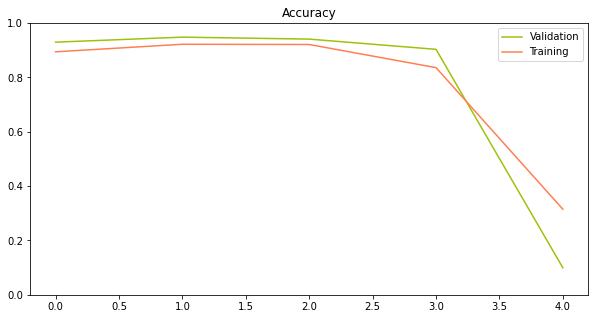

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(epochs)
ax.plot(x, val_epoch_accuracy, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_accuracy, label="Training", color="#FF7F50")
ax.set_title("Accuracy")
ax.legend()
ax.set_ylim(0,1);

# Predictive Modelling

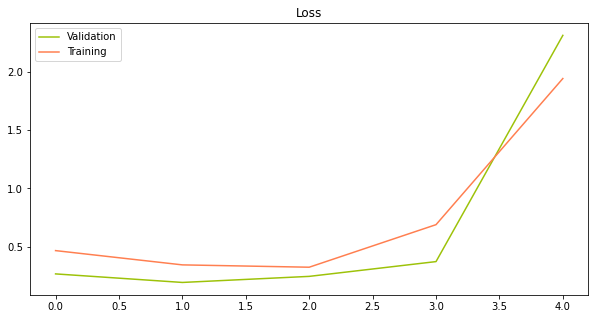

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(epochs)
ax.plot(x, val_epoch_loss, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_loss, label="Training", color="#FF7F50")
ax.legend()
ax.set_title("Loss");

# Plot Predictions
    
Visualize the model results with some example plots from the validation set.

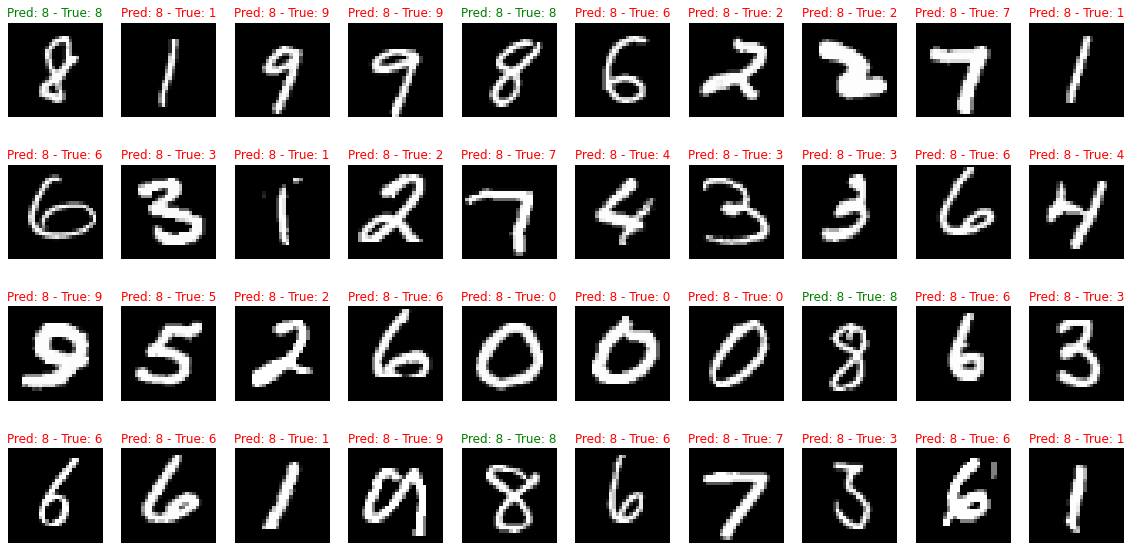

In [38]:
# first batch of validation data
X_valid = next(iter(val_dataloader))[0]
y_valid = next(iter(val_dataloader))[1]

fig, axes = plt.subplots(4,10, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_valid[i].reshape(28, 28), cmap="gray")
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[0][i].item()} - True: {int(y_valid[i].item())}',
                color=("green" if predictions[0][i]==y_valid[i] else "red"))